In [1]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle

from mplh.color_utils import create_color_df_v02
from mplh import cluster_help as ch

from src.utils import dendro_clust as dc

fig_utils from mplh


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/bestparams/"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/dendro/"

N_DONORS=2

## Parameters:
# af thresholds
# coverage threshold
# other_af thresholds
# number of cells / fraction cells
# number of other cells / fraction other cells
# af_t = 0.4
# oth_af_t = 0.1
# cov_t = 10
# oth_cov_t = 10
# ncells = 5
# oth_ncells = 0.6
# mean_pos_cov = 0

# min_cell = 10


##se_cells_meta_f = /data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simpleUnion/knn/kparam_50/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv 
#outdir = /data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/variants_simpleUnion/clonal_shifts/dendro_bc/results/inputOnly/knn/kparam_50/dendro_dt_0.6 

In [4]:
cells_dir=join(indir, "cells")

In [5]:
#samples = samples.split(",")

### Smaller params

In [6]:
def fill_mt_bin(curr_pos, curr_cells):
    print(curr_pos.name)
    curr_pos.loc[curr_cells[curr_pos.name]["other_cells"]] = 0
    curr_pos.loc[curr_cells[curr_pos.name]["clone_cells"]] = 1
    return curr_pos

In [7]:
bin_d = {}
best_params = pd.read_csv(join(indir,  "best_params.csv"))
print('params', best_params)
for d in range(N_DONORS): 
    bin_d[d] = pd.read_csv(join(indir,  f"donor_{d}_binary.csv"), index_col=0)

# for d in range(N_DONORS): 
#     curr_f = join(cells_dir, f"don.{d}_af.{af_t}_othaf.{oth_af_t}_cov.{cov_t}_othcov.{oth_cov_t}.p")
#     curr_cells = pickle.load(open(curr_f,'rb'))
#     params_results = pd.read_csv(join(indir, f"donor_{d}_thresh_results.tsv"), sep="\t")    

#     curr_p = params_results.loc[(params_results["af"]==af_t) &
#                        (params_results["oth_af"]==oth_af_t) &
#                        (params_results["cov"]==cov_t) &
#                        (params_results["oth_cov"]==oth_cov_t) &
#                        (params_results["ncells"]==ncells) &
#                        (params_results["oth_ncells"]==oth_ncells) &
#                        (params_results["mean_cov"]==mean_pos_cov)]
#     assert(len(curr_p)==1)
    
#     ## Construct a binary cell-by-variant matrix for the kept variants. 
#     ## Can add N/A if not in oth cells
#     curr_vars = curr_p.iloc[0]["Variants"].split(";")

#     all_cells = set()
#     for x in curr_cells:
#         all_cells = all_cells.union(set(curr_cells[x]["clone_cells"])) 
#         all_cells = all_cells.union(set(curr_cells[x]["other_cells"])) 

#     mt_bin = pd.DataFrame(index = all_cells, columns=curr_vars)
#     bin_d[d] = mt_bin.apply(fill_mt_bin, curr_cells=curr_cells,axis=0)
#     bin_d[d] = bin_d[d].fillna(0)


### Remove cells with all 0s and vars with less than min_cell number of cells

for d in bin_d:
    print(d)
    print(bin_d[d].shape)
    bin_d[d] = bin_d[d].loc[~((bin_d[d])==0).all(axis=1),~(bin_d[d].sum(axis=0)<min_cell)]
    print(bin_d[d].shape)

11453A
14674C
152C
16129A
1949A
2623G
3244A
8697A
8743A
10589A
11761T
146C
15297C
15497A
16129A
196C
204C
2442C
2623G
3244A
3847C
5442C
64T
827G
8292A


Donor 0
before 0 remove: (657, 9)
after 0 remove: (657, 9)
creating linkage with scipy.cluster.hierarchy.linkage
icoord and color list
656
656
leaves leaves color and df shape
657
657
(657, 9)


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Donor 1
before 0 remove: (482, 16)
after 0 remove: (482, 16)
creating linkage with scipy.cluster.hierarchy.linkage
icoord and color list
481
481
leaves leaves color and df shape
482
482
(482, 16)


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


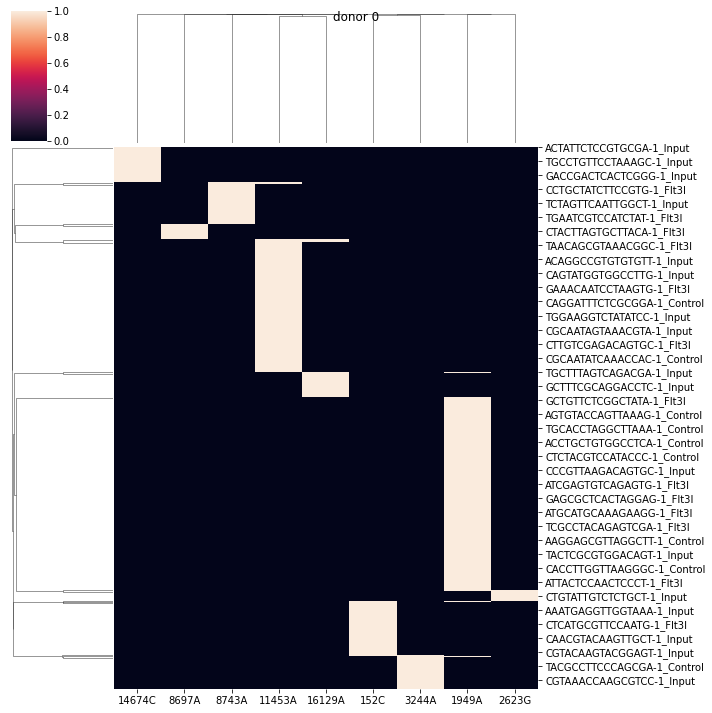

<Figure size 720x504 with 0 Axes>

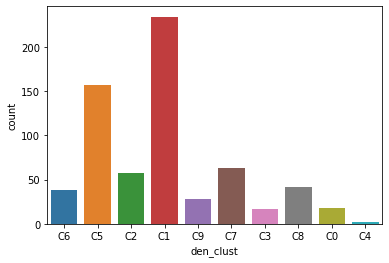

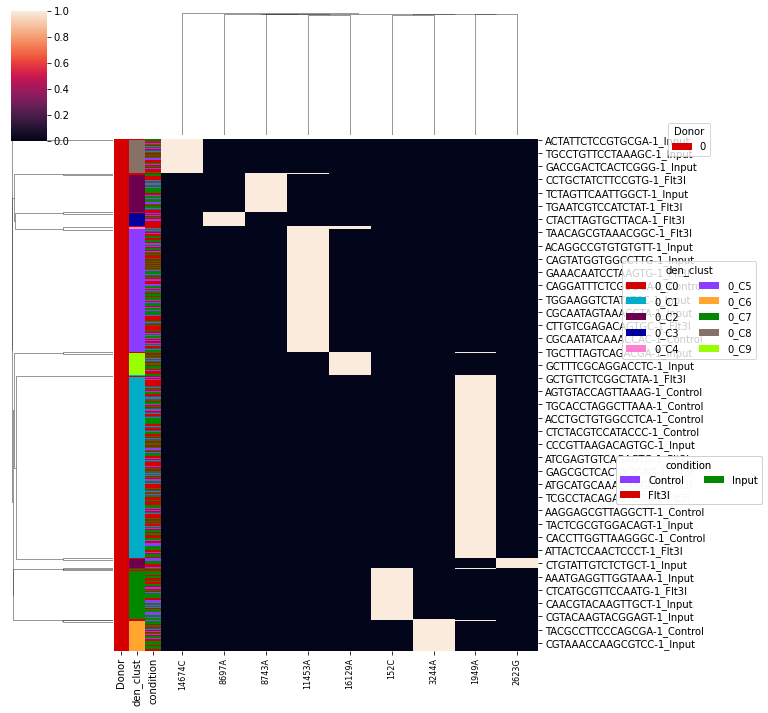

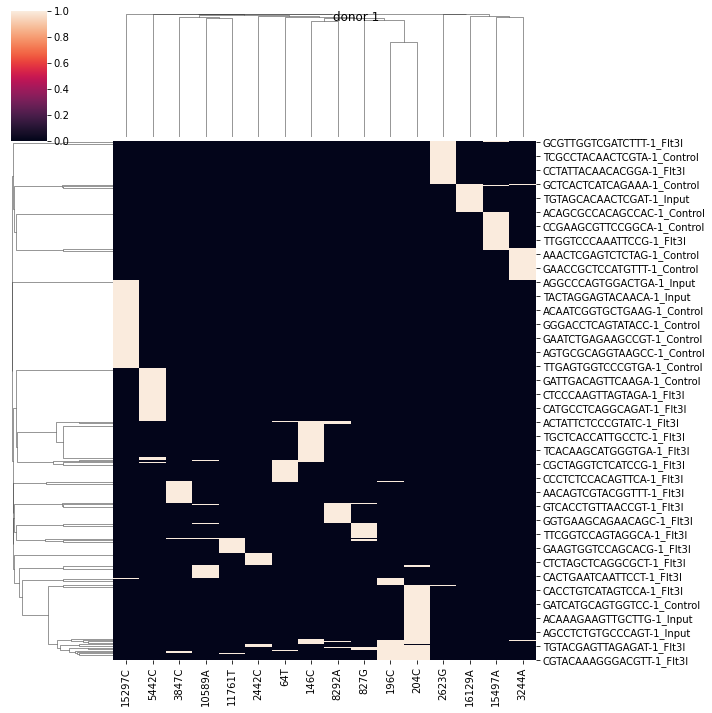

<Figure size 720x504 with 0 Axes>

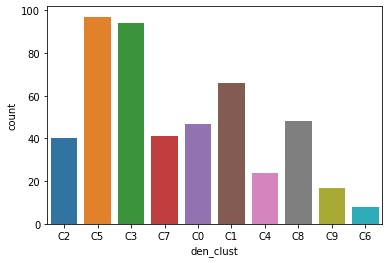

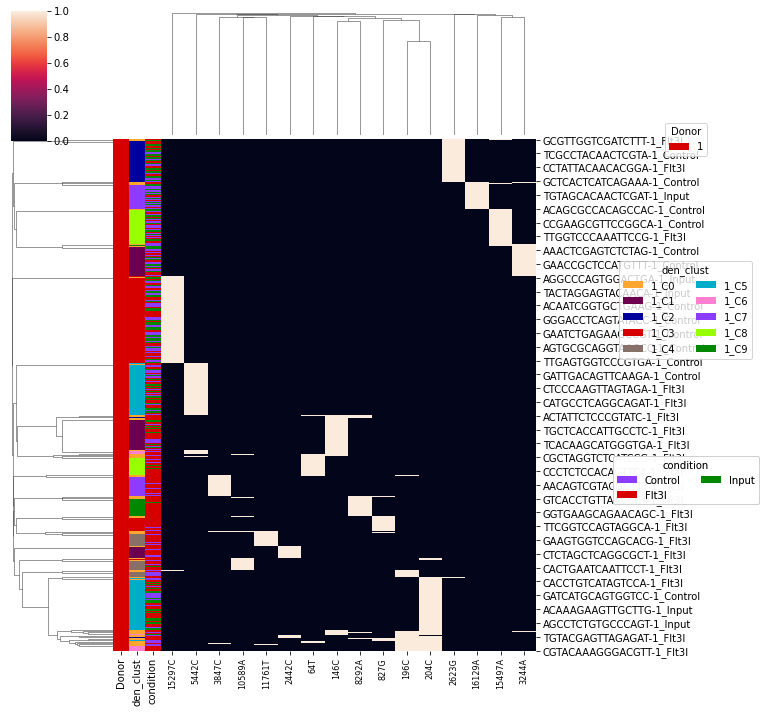

In [9]:
%matplotlib inline

for d in bin_d:
    print(f"Donor {d}")
    g = sns.clustermap(bin_d[d].fillna(0).astype(bool),metric='jaccard')
    g.fig.suptitle(f"donor {d}")
    plt.savefig(join(outdir, f"don_{d}_dendro_mt_as_clones.png"))

    
    #df = bin_d[d].fillna(0).astype(bool).sample(1000)
    df = bin_d[d].fillna(0).astype(bool)
    
    # Drop the all 0s
    print(f"before 0 remove: {df.shape}")
    df = df.loc[~((df == 0).all(axis=1))]
    curr_clones = pd.DataFrame(index=df.index)
    curr_clones["Donor"] = d
    print(f"after 0 remove: {df.shape}")    
    den, curr_clones = dc.run_dendro_clust(df, dendroThresh=0.6, curr_clones=curr_clones, out_f=None,
                                           to_clust_stats=False, use_seaborn=False, verbose=True)
    
#     g = sns.clustermap(df, row_cluster=True, col_cluster=True, metric="jaccard")
#     inds = g.dendrogram_row.dendrogram["leaves"]
#     cols = g.dendrogram_col.dendrogram["leaves"]
#     curr_clones = curr_clones.iloc[inds]
#     plt.close(g.fig)

#     den = dc.dendro_cluster(df, g, d_thresh=0.8, no_labels=True, truncate_mode= 'lastp')
#     curr_clones = dc.add_cluster_labels(den, curr_clones)
#     curr_clones

    curr_clones["condition"]= [x.split("_")[-1] for x in curr_clones.index]
    curr_clones = curr_clones.loc[df.index]
    curr_clones

    f = plt.figure()
    sns.countplot(curr_clones["den_clust"])
    curr_clones["den_clust"] = curr_clones["Donor"].astype(str) +  "_" + curr_clones["den_clust"]
    #may want to sample when plotting
    ch.plot_cluster(df.fillna(0), row_meta=curr_clones, metric="jaccard", row_clr_schemes="categorical")
    curr_clones.to_csv(join(outdir, f"don_{d}_mt_dendro_clust.csv"))

In [10]:
outdir

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/dendro/'

In [11]:
#ch.plot_cluster(df, row_meta=curr_clones, row_clr_schemes="categorical")

In [12]:
# %matplotlib inline
# df = bin_d[d].fillna(0).astype(bool).sample(1000)
# curr_clones = pd.DataFrame(index=df.index)
# curr_clones["Donor"] = d
# g = sns.clustermap(df, row_cluster=True, col_cluster=True, metric="jaccard")
# inds = g.dendrogram_row.dendrogram["leaves"]
# cols = g.dendrogram_col.dendrogram["leaves"]
# curr_clones = curr_clones.iloc[inds]
# plt.close(g.fig)

# den_high = dc.dendro_cluster(df, g, d_thresh=0.6, no_labels=True, truncate_mode= 'lastp')

# curr_clones = dc.add_cluster_labels(den_high, curr_clones)
# curr_clones

# #size_pvals = dc.cluster_stats(curr_clones, out_f= None )

# curr_clones["condition"]= [x.split("_")[-1] for x in curr_clones.index]
# curr_clones = curr_clones.loc[df.index]
# curr_clones

# f = plt.figure()
# sns.countplot(curr_clones["den_clust"])

# curr_clones["den_clust"] = curr_clones["Donor"].astype(str) +  curr_clones["den_clust"]